In [233]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

plt.rcParams['figure.figsize'] = (9, 7)


## Loading and ploting the image

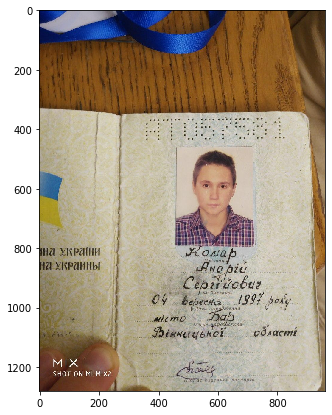

In [335]:
IMG_PATH = 'images/9.jpg'
img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_orig = img.copy()
plt.imshow(img)

## Edge detection

In [336]:
MIN_VAL = 200
MAX_VAL = 250

def detect_edges(img, min_val=MIN_VAL, max_val=MAX_VAL):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply filter, threshold and blur
    img = cv2.bilateralFilter(img, 9, 75, 75)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 4)
    img = cv2.medianBlur(img, 11)
    
    # Add border
    img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Apply Canny edge detector
    img = cv2.Canny(img, min_val, max_val)
    
    # Apply morph transformation (img => erosion => dilation)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((5, 11)))
    return img

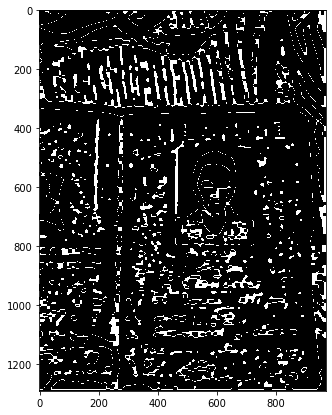

In [337]:
edges_img = detect_edges(img)
plt.imshow(edges_img, cmap='gray')

## Finding contours

In [338]:
def four_corners_sort(pts):
    """ Sort corners: top-left, bot-left, bot-right, top-right"""
    diff = np.diff(pts, axis=1)
    summ = pts.sum(axis=1)
    return np.array([pts[np.argmin(summ)],
                     pts[np.argmax(diff)],
                     pts[np.argmax(summ)],
                     pts[np.argmin(diff)]])


def contour_offset(cnt, offset):
    """ Offset contour because of 5px border """
    cnt += offset
    cnt[cnt < 0] = 0
    return cnt


def find_page_contours(edges, img):
    """ Finding corner points of page contour """
    # Getting contours  
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Finding biggest rectangle otherwise return original corners
    height = edges.shape[0]
    width = edges.shape[1]
    MIN_COUNTOUR_AREA = height * width * 0.5
    MAX_COUNTOUR_AREA = (width - 10) * (height - 10)

    max_area = MIN_COUNTOUR_AREA
    page_contour = np.array([[0, 0],
                            [0, height-5],
                            [width-5, height-5],
                            [width-5, 0]])

    for cnt in contours:
        perimeter = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.03 * perimeter, True)

        # Page has 4 corners and it is convex
        if (len(approx) == 4 and
                cv2.isContourConvex(approx) and
                max_area < cv2.contourArea(approx) < MAX_COUNTOUR_AREA):
            
            max_area = cv2.contourArea(approx)
            page_contour = approx[:, 0]

    # Sort corners and offset them
    page_contour = four_corners_sort(page_contour)
    return contour_offset(page_contour, (-5, -5))

In [339]:
def find_contours(edges_img):
    # Get contours
    contours, hierarchy = cv2.findContours(edges_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find the biggest rectangle
    height, width = edges_img.shape
    MIN_CONTOUR_AREA = width * height * 0.5

    max_area = MIN_CONTOUR_AREA
    max_contour = np.array([[0, 0],
                           [0, height],
                           [width, height],
                           [width, 0]])

    for contour in contours:
        perimeter = cv2.arcLength(contour, closed=True)
        approx = cv2.approxPolyDP(contour, 0.03 * perimeter, closed=True)

        if(len(approx) == 4 and max_area < cv2.contourArea(approx)):
            max_area = cv2.contourArea(approx)
            max_contour = approx[:, 0]
    
    return max_contour

Contours:
 [[   0  334]
 [   0 1284]
 [ 940 1284]
 [ 902  358]]


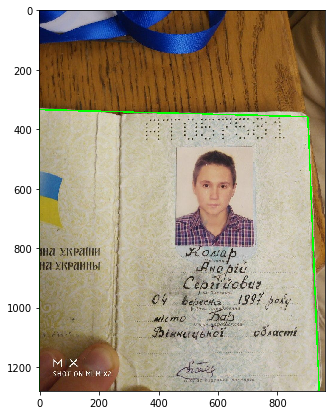

In [340]:
contours = find_contours(edges_img)
print('Contours:\n', contours)
plt.imshow(cv2.drawContours(img_orig, [contours], -1, (0, 255, 0), 3))

## Transform perspective